In [8]:
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants
import time

# --- Physical Constants ---
g = constants.g
cpd = 1005.7
Rd = 287.05
Rv = 461.5
epsilon = Rd / Rv
P0 = 100000.0
Lv = 2.501e6

# --- Thermodynamic Functions ---
def saturation_vapor_pressure(T):
    T_celsius = T - 273.15
    es_hPa = 6.112 * np.exp((17.67 * T_celsius)/(T_celsius + 243.5))
    return es_hPa * 100.0  # Pa

def saturation_specific_humidity(p, T):
    es = saturation_vapor_pressure(T)
    es = np.minimum(es, p * 0.99)
    denom = p - (1.0 - epsilon) * es
    qs = np.divide(epsilon * es, denom, out=np.full_like(denom, 1e-9), where=denom > 0)
    return np.maximum(qs, 1e-9)

def dqs_dT_approx(p_surf, T, Ts):
    T0 = (Ts + T) / 2.0
    q_vs = saturation_specific_humidity(p_surf, Ts)
    es = saturation_vapor_pressure(T)
    T_celsius = T - 273.15
    des_dT = es * (17.67 * 243.5) / (T_celsius + 243.5)**2
    a = 0
    A = cpd / (Rd * T0)
    B = Lv * q_vs / ((1 + a) * Rd * T0)
    exp_term = np.exp(A * (Ts - T) + B)
    dq_dT = (epsilon / p_surf) * (des_dT * exp_term - A * es * exp_term)
    return dq_dT

print("--- Starting Main Calculation ---")
start_time = time.time()

# --- Grid setup ---
T_surf_values = np.arange(310, 351, 1)
p_surf_pa = 100000.0
n_t = len(T_surf_values)

# --- Storage for terms ---
magnitude_ratio_surface = np.full(n_t, np.nan)
sensitivity_ratio_trop_approx = np.full(n_t, np.nan)

for j, Ts in enumerate(T_surf_values):
    print(f"Processing Ts = {Ts:.1f} K...")
    magnitude_ratio_surface[j] = (Lv / cpd) * (saturation_specific_humidity(p_surf_pa, Ts) / Ts)
    sensitivity_ratio_trop_approx[j] = (Lv / cpd) * dqs_dT_approx(p_surf_pa, 200.0, Ts)

print(f"\n--- Calculation Finished in {time.time() - start_time:.2f} seconds ---\n")

print("--- Processing Data for Figure D1 ---")
# --- Helper function for stable root interpolation ---
def find_interpolated_root(y_slice, x_vals, y_slice_for_guess=None, guess_mode='min'):
    if np.all(np.isnan(y_slice)):
        return np.nan
    # Find all sign changes
    sign_changes = np.where((y_slice[:-1] * y_slice[1:]) < 0)[0]
    # Filter for valid crossings
    k_all = []
    for k in sign_changes:
        if np.isfinite(y_slice[k]) and np.isfinite(y_slice[k + 1]):
            k_all.append(k)
    if not k_all:
        return np.nan
    # Interpolate all candidate roots
    T_candidates = []
    for k in k_all:
        T0, T1 = x_vals[k], x_vals[k + 1]
        y0, y1 = y_slice[k], y_slice[k + 1]
        if y1 == y0: continue
        T_root = T0 - y0 * (T1 - T0) / (y1 - y0)
        T_candidates.append(T_root)
    if not T_candidates:
        return np.nan
    if len(T_candidates) == 1:
        return T_candidates[0]
    # If multiple roots, use the discrete min/max as a guess
    if y_slice_for_guess is None:
        y_slice_for_guess = y_slice
    if guess_mode == 'min':
        j_guess = np.nanargmin(y_slice_for_guess)
    elif guess_mode == 'max':
        j_guess = np.nanargmax(y_slice_for_guess)
    else:  # 'abs_min'
        j_guess = np.nanargmin(np.abs(y_slice_for_guess))
    T_guess = x_vals[j_guess]
    # Return the candidate root closest to the discrete guess
    T_best = min(T_candidates, key=lambda T: abs(T - T_guess))
    return T_best

# --- Find T_s where each term = 1 ---
Ts_mgh = find_interpolated_root(magnitude_ratio_surface - 1, T_surf_values, guess_mode='abs_min')
Ts_peak_approx = find_interpolated_root(sensitivity_ratio_trop_approx - 1, T_surf_values, guess_mode='abs_min')


--- Starting Main Calculation ---
Processing Ts = 310.0 K...
Processing Ts = 311.0 K...
Processing Ts = 312.0 K...
Processing Ts = 313.0 K...
Processing Ts = 314.0 K...
Processing Ts = 315.0 K...
Processing Ts = 316.0 K...
Processing Ts = 317.0 K...
Processing Ts = 318.0 K...
Processing Ts = 319.0 K...
Processing Ts = 320.0 K...
Processing Ts = 321.0 K...
Processing Ts = 322.0 K...
Processing Ts = 323.0 K...
Processing Ts = 324.0 K...
Processing Ts = 325.0 K...
Processing Ts = 326.0 K...
Processing Ts = 327.0 K...
Processing Ts = 328.0 K...
Processing Ts = 329.0 K...
Processing Ts = 330.0 K...
Processing Ts = 331.0 K...
Processing Ts = 332.0 K...
Processing Ts = 333.0 K...
Processing Ts = 334.0 K...
Processing Ts = 335.0 K...
Processing Ts = 336.0 K...
Processing Ts = 337.0 K...
Processing Ts = 338.0 K...
Processing Ts = 339.0 K...
Processing Ts = 340.0 K...
Processing Ts = 341.0 K...
Processing Ts = 342.0 K...
Processing Ts = 343.0 K...
Processing Ts = 344.0 K...
Processing Ts = 345.0

--- Generating Figure D1 ---


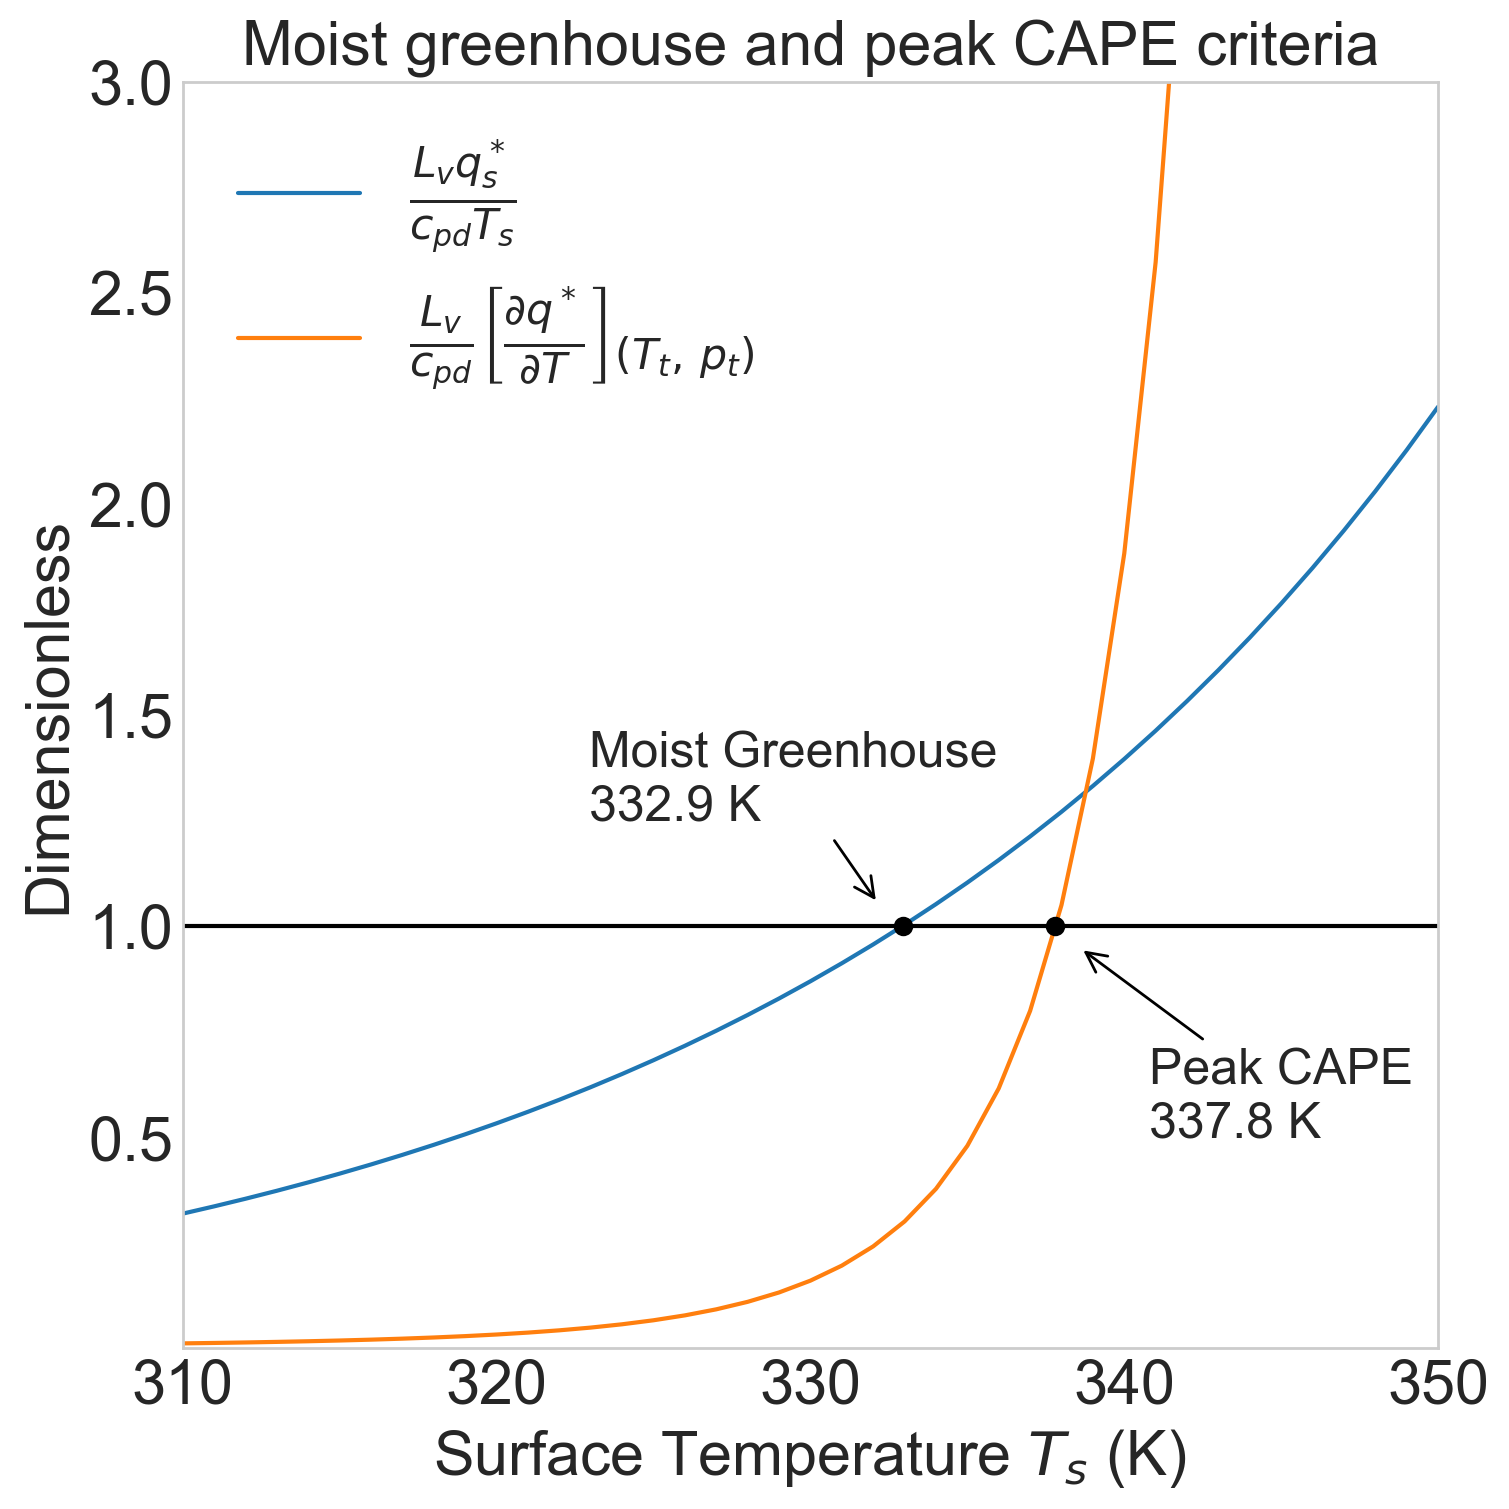

Figure D1 saved as fig-d1.png

Script finished.


In [9]:
print("--- Generating Figure D1 ---")
plt.style.use('seaborn-v0_8-whitegrid')
base_fontsize = 22
plt.rcParams.update({
    'font.size': base_fontsize,
    'axes.titlesize': base_fontsize,
    'axes.labelsize': base_fontsize,
    'xtick.labelsize': base_fontsize,
    'ytick.labelsize': base_fontsize,
    'legend.fontsize': base_fontsize,
    'figure.titlesize': base_fontsize + 2
})
fig, ax = plt.subplots(figsize=(8, 8))
# --- Plots ---
ax.axhline(1, color='black', linestyle='-')
ax.plot(T_surf_values, magnitude_ratio_surface, label='$\\frac{L_v q_s^*}{c_{pd}T_s}$')
ax.plot(T_surf_values, sensitivity_ratio_trop_approx, label='$\\frac{L_v}{c_{pd}}\\left[\\frac{\\partial q^*}{\\partial T}\\right]_{(T_t,\\,p_t)}$')
# --- Annotations for crossings at 1 ---
if not np.isnan(Ts_mgh):
    ax.plot(Ts_mgh, 1, 'o', color='black')
    ax.annotate(f'Moist Greenhouse\n{Ts_mgh:.1f} K', xy=(Ts_mgh-0.75, 1.05), xytext=(Ts_mgh - 10, 1.25),
                arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=base_fontsize - 4, ha='left')
if not np.isnan(Ts_peak_approx):
    ax.plot(Ts_peak_approx, 1, 'o', color='black')
    ax.annotate(f'Peak CAPE\n{Ts_peak_approx:.1f} K', xy=(Ts_peak_approx+0.75, 0.95), xytext=(Ts_peak_approx + 3, 0.5),
                arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=base_fontsize - 4, ha='left')
# Formatting
ax.set_xlabel('Surface Temperature $T_s$ (K)')
ax.set_ylabel('Dimensionless')
ax.set_title('Moist greenhouse and peak CAPE criteria')
ax.set_xlim(310, 350)
ax.set_ylim(0, 3)
ax.set_yticks(np.arange(0.5, 3.5, 0.5))
ax.legend(loc='upper left')
ax.grid(False)
plt.tight_layout()
fig_d1_filename = "fig-d1.png"
plt.savefig(fig_d1_filename, dpi=300, bbox_inches='tight')
plt.show()
print(f"Figure D1 saved as {fig_d1_filename}")

print("\nScript finished.")
